In [2]:

# Projet: Facebook BaBi tasks
Notebook de la semaine du 22/03
Par Thierry Loesch et Bryce Tichit

Dernier notebook

Comme demandé par notre tuteur, nous allons désormais essayer d'adapter les travaux fait jusqu'ici sur un autre projet sensiblement identique.

-----------------------------------

5.1  Notation automatique de réponses courtes à des questions

Les données sont ici pour le téléchargement et leur description est dans cet article

Lorsque l'on connait:

    une question,
    une réponse d'un étudiant,
    la bonne réponse, 

comment prédire la note à donné à la réponse de l'étudiant. Il peut être aussi intéressant d'essayer d'apprendre à générer la réponse. 

--------------------------

On cherchera en premier à prédire la note de l'étudiant, le réseau devra rendre un réel. Normaliser les notes (les mettre entre 0 et 1) et activation par Sigmoid (output entre 0 et 1) afin de prédire la note.

SyntaxError: invalid syntax (<ipython-input-2-9702dd9b3a10>, line 3)

In [1]:
import re
from keras.utils.data_utils import get_file
import zipfile
import string
import nltk
from nltk.corpus import wordnet
#import gensim
#from gensim import models

def tokenize(sent):
    
    def remPunctuation(sent):
        return "".join(l for l in sent if l not in string.punctuation)
        
    return [x.strip() for x in re.split('(\W+)?', remPunctuation(sent.lower())) if x.strip()]

def parseData(questions,answers,student_answers=''):
    
    #questions_data = dict() #ce dictionnaire contiendra les tuples (question,answer) indexés par la clé "numéro de question"
    
    questions_data = dict()
    
    for line in questions.split('\n'): #une ligne = une question
        line = line.decode('utf-8').strip()
        try:
            index,question = line.split(' ',1)
        except:
            continue
        
        questions_data[index] = [question.replace('<STOP>',''),None]
    
    for line in answers.split('\n'):
        line = line.decode('utf-8').strip()
        
        try:
            index,answer = line.split(' ',1)
        except:
            continue
            
        questions_data[index][1] = answer.replace('<STOP>','')
        
    questions_data = {k: tuple(map(tokenize,v)) for k, v in questions_data.items()}
    
    stud_ans = dict()
    
    for line in student_answers.split('\n'):
        line = line.decode('utf-8')
        try:
            index,ans = line.split(' ',1)
        except:
            continue
            
        answers=ans.split('<STOP>')
        answers=[a for a in answers if a]
            
        if index in stud_ans:
            stud_ans[index] += map(tokenize,answers)
        else:
            stud_ans[index] = map(tokenize,answers)
    
    return questions_data,stud_ans
        
    
def parseIntoExamples(qd,sa):
    
    ret = list()
    
    for index,q_a in qd.items():
        scores = [k for k in archive.read('data/scores/'+str(index+'/ave')).split('\n') if k]
        for stud_ans,score in zip(sa[index],scores):
            ret.append((q_a[0],q_a[1],stud_ans,float(score)/5.))
    return ret

#print 'loading'
#model = gensim.models.KeyedVectors.load_word2vec_format('G:/GoogleNews-vectors-negative300.bin.gz', binary=True)
#print 'done'
                       


    

Using Theano backend.


In [3]:
from collections import defaultdict
from itertools import chain

try:
    path = get_file('shortAnswerGrading-v-2-0.zip',origin='http://web.eecs.umich.edu/~mihalcea/downloads/ShortAnswerGrading_v2.0.zip')
except:
    print "error while downloading file"
    
    
archive = zipfile.ZipFile(path,'r')
    
questions = archive.read('data/sent/questions') 
answers = archive.read('data/sent/answers')
student_answers = archive.read('data/sent/all') 

dic1,dic2 = parseData(questions,answers,student_answers)


data = parseIntoExamples(dic1,dic2)

nbSamples = len(data)

data_train = data[0:nbSamples/2]
data_test = data[(nbSamples/2):-1]

#print data[0]

vocab = set()
for (a,b,c,_) in data:
    for x in [a,b,c]:
        vocab.update(x)
vocab=sorted(list(vocab))

grouped_vocab = defaultdict(list)
for w in vocab:
    synonyms = wordnet.synsets(w)
    lemmas = set(chain.from_iterable([word.lemma_names() for word in synonyms]))
    intersection = list(set(lemmas) & set(grouped_vocab.keys()))
    if intersection == []:
        grouped_vocab[w].append(w)
    else:
        for v in intersection:
            if (v in grouped_vocab.keys()):
                grouped_vocab[v].append(w)

for k in grouped_vocab:
    grouped_vocab[k] = list(set(grouped_vocab[k]))
    #grouped_vocab[k].insert(0 , grouped_vocab[k].pop(grouped_vocab[k].index(k)))

vocab_word_to_synonym = {}
for k in grouped_vocab:
    for v in grouped_vocab[k]:
        vocab_word_to_synonym[v]=k
        

print len(vocab)
print len(grouped_vocab)
print len(vocab_word_to_synonym)
#print vocab_word_to_synonym

vocab_size = len(vocab) +1
word_idx_before_synonyms = dict((c,i+1) for i,c in enumerate(vocab))
word_idx = vocab_word_to_synonym
for k in word_idx:
    word_idx[k] = word_idx_before_synonyms[word_idx[k]]
question_maxsize = max((len(x) for x,_,_,_ in data))
answer_stud_maxsize = max(len(x) for _,_,x,_ in data)
answer_maxsize = max((len(x) for _,x,_,_ in data))



2223
1290
2223


On a créé un dictionnaire grouped_vocab de listes, qui regroupe les mots du vocabulaire autour d'un même synonyme.
Et le dictionnaire vocab_word_to_synonym, qui pour chaque mot du vocabulaire lui associe son synonyme en valeur.

A faire:
- On pourrait encore faire du stemming pour augmenter le nombre d'association et réduire d'avantage le vocabulaire


In [4]:
#Mettons tout ça dans des matrices
from keras.preprocessing.sequence import pad_sequences
import numpy as np

#précision de 50% avec question , stud_answer , score

def vectorize(data,wordidx,qmaxlen,amaxlen):
    X,Xs,Y = list(),list(),list()
    
    lookup = lambda m : wordidx[m]
    
    for question, ans , student_answer, score in data:
        X.append(map(lookup,ans))
        Xs.append(map(lookup,student_answer))
        Y.append(score)
        
    return pad_sequences(X, maxlen=qmaxlen), pad_sequences(Xs, maxlen=amaxlen), np.array(Y)      
    
X,Xq,Y = vectorize(data_train,word_idx,answer_maxsize,answer_stud_maxsize)
X_test,Xq_test,Y_test = vectorize(data_test,word_idx,answer_maxsize,answer_stud_maxsize)
#X_test,Xq_test,Y_test = vectorize(test,word_idx,story_max,question_max)
#X_val,Xq_val,Y_val = vectorize(validation,word_idx,story_max,question_max)

In [5]:
print X[0:10]
print Xq[0:10]
print Y[0:10]

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 2018
    76 1333 2018 1162  949 1230 2181 2018  832  337 1695]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 2018
    76 1333 2018 1162  949 1230 2181 2018  832  337 1695]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 2018
    76 1333 2018 1162  949 1230 2181 2018  832  337 1695]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   

# Modele

Il s'agit du même modèle que pour les babi-tasks mais legèrement modifié, voir ce qu'on peut tenter comme modèle (question? answer? stud_answer?) mais à priori garder la même architecture.

Actuellement les performances sont faibles à cause de la taille du vocabulaire (embed_size trop petit pour sa taille) il faut augmenter l'embed_size de manière raisonnable mais aussi diminuer la taille du vocabulaire

In [6]:
#Model

from keras.layers.embeddings import Embedding
from keras.layers import Dense, Merge,RepeatVector,Activation
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam


embed_size = 100
batch_size=256
epochs=10

question_model = Sequential()
question_model.add(Embedding(vocab_size,embed_size,input_length=answer_maxsize))
question_model.add(LSTM(embed_size))

ans_model = Sequential()
ans_model.add(Embedding(vocab_size,embed_size,input_length=answer_stud_maxsize))
ans_model.add(LSTM(embed_size))
#ans_model.add(RepeatVector(answer_maxsize)) #permet d'ajuster la taille du modèle afin de préparer un merge


model = Sequential()
model.add(Merge([question_model, ans_model], mode='concat',concat_axis=1))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(optimizer=Adam(lr=0.01),loss='mse',metrics=['accuracy'])

model.summary()

history = model.fit([X, Xq], Y, batch_size=batch_size, nb_epoch=epochs)

F:\Users\ABE\Anaconda2\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 605,801
Trainable params: 605,801
Non-trainable params: 0
_________________________________________________________________


F:\Users\ABE\Anaconda2\lib\site-packages\keras\models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
1221/1221 [==============================] - 7s - loss: 0.0926 - acc: 0.4545     
Epoch 2/10
1221/1221 [==============================] - 9s - loss: 0.0562 - acc: 0.4914     
Epoch 3/10
1221/1221 [==============================] - 10s - loss: 0.0473 - acc: 0.4914    
Epoch 4/10
1221/1221 [==============================] - 12s - loss: 0.0424 - acc: 0.4914    
Epoch 5/10
1221/1221 [==============================] - 13s - loss: 0.0387 - acc: 0.4914    
Epoch 6/10
1221/1221 [==============================] - 14s - loss: 0.0358 - acc: 0.4939    
Epoch 7/10
1221/1221 [==============================] - 16s - loss: 0.0333 - acc: 0.4930    
Epoch 8/10
1221/1221 [==============================] - 20s - loss: 0.0313 - acc: 0.4955    
Epoch 9/10
1221/1221 [==============================] - 21s - loss: 0.0291 - acc: 0.4955    
Epoch 10/10
1221/1221 [==============================] - 22s - loss: 0.0263 - acc: 0.4963    


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotLearningCurves_acc(history_model,save=''):
    plt.plot(history_model.history['acc'])
    plt.plot(history_model.history['val_acc'])
    plt.title('Precision du modele')
    plt.ylabel('Precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()
    
def plotLearningCurves_loss(history_model,save=''):
    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('Perte sur le modele')
    plt.ylabel('Perte')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()

1220/1220 [==============================] - 5s     

Perte = 0.068
Précision = 51%


KeyError: 'val_acc'

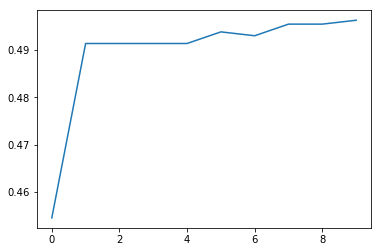

In [8]:
#Calcul de précision sur l'ensemble de test

loss,acc = model.evaluate([X_test,Xq_test],Y_test, batch_size=batch_size)
print "\nPerte = {:.3f}".format(loss)
print "Précision = {:.0f}%".format(acc*100)

plotLearningCurves_acc(history)

plotLearningCurves_loss(history)